# Next-Frame Video Prediction with Convolutional LSTMs

**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2023/11/10<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [18]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 257.


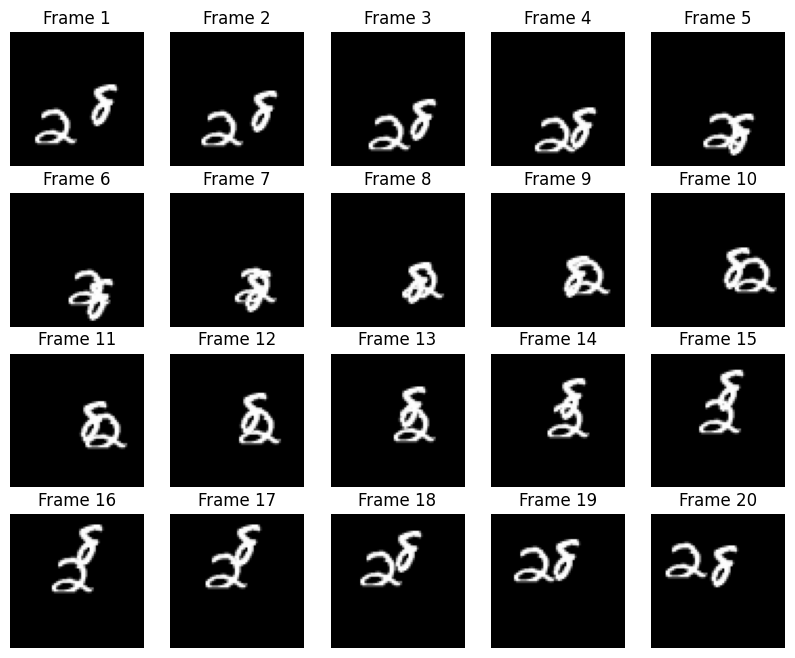

In [19]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

## Improved Model

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os

In [24]:
os.chdir("/content/drive/MyDrive/VAPAAD/output")

In [25]:
from datetime import datetime

def datetime_to_string(dt: datetime) -> str:
    """
    Convert a datetime object to a string in the format YYYY_MM_DD.

    Parameters:
    dt (datetime): The datetime object to convert.

    Returns:
    str: The formatted date string.
    """
    return dt.strftime("%Y_%m_%d")

# Example usage
current_datetime = datetime.now()
formatted_date = datetime_to_string(current_datetime)
print(formatted_date)

2024_12_29


### Model: ConvLSTM + Attention Layer

In [ ]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs):
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

def build_model(input_shape, num_spatial_block=2):
    inp = layers.Input(shape=input_shape)

    x = inp
    for i in range(num_spatial_block):
        x = layers.ConvLSTM2D(
            filters=48, kernel_size=(5, 5), padding="same", return_sequences=True,
            activation="relu", kernel_regularizer=regularizers.l2(1e-5)
        )(x)
        x = naive_spatial_attention(x)  # Naive spatial attention
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)  # Dropout for regularization

    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)

    return model

### Model: ConvLSTM + AE + Skip

In [8]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs):
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

def build_model(input_shape, num_spatial_block=2):
    inp = layers.Input(shape=input_shape)

    # Encoder path with ConvLSTM2D blocks
    encoder_outputs = []
    x = inp
    for i in range(num_spatial_block):
        x = layers.ConvLSTM2D(
            filters=48, kernel_size=(5, 5), padding="same", return_sequences=True,
            activation="relu", kernel_regularizer=regularizers.l2(1e-5)
        )(x)
        x = naive_spatial_attention(x)  # Naive spatial attention
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)  # Dropout for regularization
        encoder_outputs.append(x)  # Save output for skip connection

    # Bottleneck layer (central part of U-Net)
    x = layers.ConvLSTM2D(
        filters=64, kernel_size=(5, 5), padding="same", return_sequences=True,
        activation="relu", kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    x = naive_spatial_attention(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Decoder path with ConvLSTM2D blocks and skip connections
    for i in reversed(range(num_spatial_block)):
        x = layers.ConvLSTM2D(
            filters=48, kernel_size=(5, 5), padding="same", return_sequences=True,
            activation="relu", kernel_regularizer=regularizers.l2(1e-5)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, encoder_outputs[i]])  # Apply skip connection
        x = layers.Dropout(0.2)(x)

    # Final Conv3D layer for spatiotemporal output
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)

    return model


### Model: Custom Conv2D

In [16]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs: tf.Tensor) -> tf.Tensor:
    """
    Applies a naive spatial attention by averaging across spatial dimensions
    and using a dense layer to produce a spatial attention map.
    """
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

class PatchEmbeddingLayer(layers.Layer):
    """
    A custom layer that applies a convolution to emulate patch extraction,
    and then applies a learnable embedding projection (another convolution)
    to produce a trainable embedded representation.

    This layer:
    - Takes input of shape (b, t, h, w, c).
    - Applies a TimeDistributed Conv2D to extract patch-like features.
    - Applies a TimeDistributed 1x1 Conv2D to produce a trainable embedding.
    - Outputs (b, t, h, w, filters).
    """

    def __init__(self, filters: int = 48, kernel_size: int = 5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        # These will be built once input shape is known
        self.patch_conv = None
        self.embedding_conv = None

    def build(self, input_shape):
        # input_shape is (b, t, h, w, c)
        # We'll create patch-based convolution: a small kernel to emulate patch extraction
        # Here, kernel_size=5 is arbitrary; you can adjust as needed.
        self.patch_conv = layers.TimeDistributed(
            layers.Conv2D(
                filters=self.filters,
                kernel_size=(self.kernel_size, self.kernel_size),
                padding='same',
                activation='relu',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )

        # Another TimeDistributed Conv2D with kernel_size=1 to act as a learnable embedding
        self.embedding_conv = layers.TimeDistributed(
            layers.Conv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                activation='linear',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )
        super().build(input_shape)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        # x: (b, t, h, w, c)
        x = self.patch_conv(x)      # (b, t, h, w, filters)
        x = self.embedding_conv(x)  # (b, t, h, w, filters)
        return x

def build_model(input_shape: tuple[int, int, int, int, int], num_spatial_block: int = 2) -> tf.keras.Model:
    """
    Builds a model for next frame prediction using a U-Net style architecture.
    Instead of ConvLSTM2D, we use a PatchEmbeddingLayer that applies a convolution
    to extract patch-like features and then a trainable embedding projection.

    Args:
        input_shape: (time, height, width, channels).
        num_spatial_block: Number of spatial blocks in the encoder and decoder.

    Returns:
        A Keras Model object.
    """
    inp = layers.Input(shape=input_shape)

    encoder_outputs = []
    x = inp
    for i in range(num_spatial_block):
        # Use PatchEmbeddingLayer instead of ConvLSTM2D
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = naive_spatial_attention(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        encoder_outputs.append(x)

    # Bottleneck layer (using PatchEmbeddingLayer instead of ConvLSTM2D)
    x = PatchEmbeddingLayer(filters=64, kernel_size=5)(x)
    x = naive_spatial_attention(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Decoder path
    for i in reversed(range(num_spatial_block)):
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, encoder_outputs[i]])
        x = layers.Dropout(0.2)(x)

    # Final Conv3D layer for spatiotemporal output
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)
    return model

### Model: Custom Conv2D + Custom Patch Embedding + Attention

In [26]:
from typing import Optional, Tuple, Union
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D

class CustomConv2D(Conv2D):
    """
    A custom 2D convolution layer that applies a softmax activation
    along the channel dimension after performing the convolution.

    This layer inherits from `tf.keras.layers.Conv2D` and overrides the
    `call` method to pass the convolution output through a softmax function.

    Args:
        filters: Integer, the dimensionality of the output space
                 (i.e. the number of filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the
                     height and width of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers, specifying the strides
                 of the convolution along the height and width.
                 (default: (1, 1))
        padding: One of "valid" or "same" (case-insensitive).
                 (default: "valid")
        data_format: A string, one of "channels_last" or "channels_first".
                     (default: "channels_last")
        dilation_rate: An integer or tuple/list of 2 integers, specifying
                       the dilation rate to use for dilated convolution.
                       (default: (1, 1))
        activation: Activation function not needed here as we will apply softmax
                    manually.
        use_bias: Boolean, whether the layer uses a bias vector.
                  (default: True)
        kernel_initializer: Initializer for the kernel weights matrix.
        bias_initializer: Initializer for the bias vector.
        kernel_regularizer: Regularizer function applied to the kernel weights matrix.
        bias_regularizer: Regularizer function applied to the bias vector.
        activity_regularizer: Regularizer function applied to the output of the layer.
        kernel_constraint: Constraint function applied to the kernel matrix.
        bias_constraint: Constraint function applied to the bias vector.
    """

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Call method that performs the convolution and then applies a softmax
        along the channel dimension.

        Args:
            inputs: A 4D tensor with shape
                    (batch_size, height, width, channels) if data_format='channels_last'.

        Returns:
            A 4D tensor of the same shape as `inputs`, after the convolution
            and softmax activation.
        """
        # Perform the standard convolution
        x = super().call(inputs)
        # Apply softmax along the channel dimension
        # Assuming channels_last format, softmax is applied along axis = -1
        x = tf.nn.softmax(x, axis=-1)
        return x

In [27]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs: tf.Tensor) -> tf.Tensor:
    """
    Applies a naive spatial attention by averaging across spatial dimensions
    and using a dense layer to produce a spatial attention map.
    """
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

class PatchEmbeddingLayer(layers.Layer):
    """
    A custom layer that applies a convolution to emulate patch extraction,
    and then applies a learnable embedding projection (another convolution)
    to produce a trainable embedded representation.

    This layer:
    - Takes input of shape (b, t, h, w, c).
    - Applies a TimeDistributed Conv2D to extract patch-like features.
    - Applies a TimeDistributed 1x1 Conv2D to produce a trainable embedding.
    - Outputs (b, t, h, w, filters).
    """

    def __init__(self, filters: int = 48, kernel_size: int = 5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        # These will be built once input shape is known
        self.patch_conv = None
        self.embedding_conv = None

    def build(self, input_shape):
        # input_shape is (b, t, h, w, c)
        # We'll create patch-based convolution: a small kernel to emulate patch extraction
        # Here, kernel_size=5 is arbitrary; you can adjust as needed.
        self.patch_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(self.kernel_size, self.kernel_size),
                padding='same',
                activation='relu',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )

        # Another TimeDistributed Conv2D with kernel_size=1 to act as a learnable embedding
        self.embedding_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                activation='linear',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )
        super().build(input_shape)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        # x: (b, t, h, w, c)
        x = self.patch_conv(x)      # (b, t, h, w, filters)
        x = self.embedding_conv(x)  # (b, t, h, w, filters)
        return x

def build_model(input_shape: tuple[int, int, int, int, int], num_spatial_block: int = 2) -> tf.keras.Model:
    """
    Builds a model for next frame prediction using a U-Net style architecture.
    Instead of ConvLSTM2D, we use a PatchEmbeddingLayer that applies a convolution
    to extract patch-like features and then a trainable embedding projection.

    Args:
        input_shape: (time, height, width, channels).
        num_spatial_block: Number of spatial blocks in the encoder and decoder.

    Returns:
        A Keras Model object.
    """
    inp = layers.Input(shape=input_shape)

    encoder_outputs = []
    x = inp
    for i in range(num_spatial_block):
        # Use PatchEmbeddingLayer instead of ConvLSTM2D
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = naive_spatial_attention(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        encoder_outputs.append(x)

    # Bottleneck layer (using PatchEmbeddingLayer instead of ConvLSTM2D)
    x = PatchEmbeddingLayer(filters=64, kernel_size=5)(x)
    x = naive_spatial_attention(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Decoder path
    for i in reversed(range(num_spatial_block)):
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, encoder_outputs[i]])
        x = layers.Dropout(0.2)(x)

    # Final Conv3D layer for spatiotemporal output
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)
    return model

### Training

In [ ]:
if True:
    import gc
    import tensorflow as tf
    from keras import backend as K

    # Delete any specific variables or models you no longer need
    del model  # or any large variable occupying memory

    # Run garbage collection
    gc.collect()

    # Clear TensorFlow session to free up GPU memory
    K.clear_session()

In [ ]:
if True:
    # Reset TensorFlow session
    tf.keras.backend.clear_session()

In [ ]:
! nvidia-smi

Sat Dec 14 16:55:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              29W /  70W |    111MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
input_dim = list(x_train.shape)
output_dim = list(y_train.shape)
print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

input_dim_str = [input_dim[i] for i in range(len(input_dim))]
output_dim_str = [output_dim[i] for i in range(len(output_dim))]
print(f"Input dimension: {input_dim_str}")
print(f"Output dimension: {output_dim_str}")

input_dim = "_".join(map(str, input_dim_str))
output_dim = "_".join(map(str, output_dim_str))
print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

Input dimension: [900, 19, 64, 64, 1]
Output dimension: [900, 19, 64, 64, 1]
Input dimension: [900, 19, 64, 64, 1]
Output dimension: [900, 19, 64, 64, 1]
Input dimension: 900_19_64_64_1
Output dimension: 900_19_64_64_1


In [29]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Device name: ", tf.test.gpu_device_name())

Num GPUs Available:  1
Device name:  /device:GPU:0


In [ ]:
%%time

# Define model: vid2vid
num_spatial_block = 5
model = build_model(input_shape=(None, *x_train.shape[2:]), num_spatial_block=num_spatial_block)

# Compile
lr = 1e-5
wd = 1e-4
cv = 3.0
optimizer = optimizers.AdamW(learning_rate=lr, weight_decay=wd, clipvalue=cv)
model.compile(
    loss=losses.binary_crossentropy,
    optimizer=optimizer,
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=1)

# Define modifiable training hyperparameters.
epochs = 200
batch_size = 1

# with tf.device('/device:GPU:0'):
# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 393s 315ms/step - loss: 0.6736 - val_loss: 0.5054 - learning_rate: 1.0000e-05
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 259s 288ms/step - loss: 0.4426 - val_loss: 0.2939 - learning_rate: 1.0000e-05
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 288ms/step - loss: 0.2674 - val_loss: 0.2219 - learning_rate: 1.0000e-05
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - loss: 0.2099 - val_loss: 0.1933 - learning_rate: 1.0000e-05
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - loss: 0.1896 - val_loss: 0.1777 - learning_rate: 1.0000e-05
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - loss: 0.1709 - val_loss: 0.1407 - learning_rate: 1.0000e-05
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 261s 290ms/step - loss: 0.1301 - val_loss: 0.1078 - learning_rate: 1.0000e-05
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - loss: 0.1073 - val_loss: 0.0995 - learning_rate: 1.0000e-05
Epoch 9/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 260s 28

In [ ]:
import pandas as pd

In [ ]:
# model_name = "convlstm_attention"
model_name = "custom_conv2d_design"
# model_name = "convlstm_ae_skip"
# model_name = "custom_conv2d"
file_name = f"model_info_{model_name}_{formatted_date}_numblock_{num_spatial_block}_epochs_{epochs}_batch_{batch_size}_lr_{lr}_wd_{wd}_cv_{cv}_history_inputseq_{input_dim}_and_outputseq_{output_dim}"
print(f"File name: {file_name}")

In [ ]:
try:
    if True:
        pd.DataFrame(model.history.history).to_csv(f"{file_name}.csv")
except:
    print("No history found.")

### Predicting Frames

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Save the figure
plt.savefig(f"{file_name}_pred_frames_comparison.png", bbox_inches="tight")

# Display the figure.
plt.show()

### Predicting Videos

Save as `.gif`

Save `vid2vid` model to `.gif`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Prepare arrays to store the ground truth and predicted frames
truth_frames = np.zeros((5, 20, 64, 64, 1))  # (samples, frames, height, width, channels)
predicted_frames = np.zeros((5, 20, 64, 64, 1))  # (samples, frames, height, width, channels)

# Generate predictions and store them in the tensor
for idx, example in enumerate(examples):
    frames = example[:10, ...]  # First 10 frames
    original_frames = example[10:, ...]  # Last 10 frames as ground truth
    new_predictions = np.zeros((10, *frames[0].shape))  # Predicted frames container

    for i in range(10):
        frames = example[: 10 + i + 1, ...]  # Incremental frame input
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame  # Store the latest prediction

    # Store both ground truth and predictions for each sample
    truth_frames[idx] = np.concatenate([frames[:10], original_frames], axis=0)
    predicted_frames[idx] = np.concatenate([frames[:10], new_predictions], axis=0)

# Create GIF showing 5x2 grid of ground truth and predictions for each frame sequence
frames_list = []
for frame_idx in range(20):  # Loop through 20 frames
    fig, axs = plt.subplots(5, 2, figsize=(5, 10))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    for row in range(5):
        # True image
        axs[row, 0].imshow(truth_frames[row, frame_idx].squeeze(), cmap="gray")
        axs[row, 0].axis("off")
        if frame_idx == 0:
            axs[row, 0].set_title("Truth")

        # Predicted image
        axs[row, 1].imshow(predicted_frames[row, frame_idx].squeeze(), cmap="gray")
        axs[row, 1].axis("off")
        if frame_idx == 0:
            axs[row, 1].set_title("Prediction")

    # Add timestamp to the top left of the figure
    fig.text(0.3, 0.93, f'Timestamp: t={frame_idx + 1} \nleft column = truth, \nright column = pred', ha='center', va='center', transform=fig.transFigure)

    # Convert figure to image and add to frames list
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    frames_list.append(imageio.imread(buf))
    buf.close()
    plt.close(fig)

# Save the frames list as a single GIF
with io.BytesIO() as gif:
    imageio.mimsave(f"{file_name}_pred_comparison_anno.gif", frames_list, duration=300)
    gif_bytes = gif.getvalue()

# Display the GIF inline
from IPython.display import Image
display(Image(f"{file_name}_pred_comparison_anno.gif"))
